Camembert pour les designations

- On entraine
- On sauve le modele
- On Evalue le modele
- On recharge le modele, génère les embeddings et les sauve dans un CSV

In [1]:
from RktnChallenge.RktnModel import ModelTrainer



import tensorflow as tf

import pandas as pd
import numpy as np
import ast
import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFFlaubertForSequenceClassification
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import AdamW


# Reste du code (reprend à partir de la définition de convert_and_join)

trainer = ModelTrainer("data_tr_lemm.csv", "")
nb_epochs = 20
num_categories = 27
max_features = 400
checkpoint_path = "flaubert_best_desc_sum"

def convert_and_join(str_list):
    try:
        # Convertir la chaîne en liste
        real_list = ast.literal_eval(str_list)
        # Joindre la liste pour former une chaîne
        return " ".join(real_list)
    except (ValueError, SyntaxError):
        return ""


# Charger le modèle Flaubert et le tokenizer
modelpoint = 'jplu/tf-flaubert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(modelpoint)
model = TFFlaubertForSequenceClassification.from_pretrained(modelpoint, num_labels=num_categories)

labels = y = trainer.encodeLabel("prdtypecode")
#sentences =  trainer.data["designation_tkn_lemm"].apply(convert_and_join).values.tolist()
sentences =  trainer.data["tr_description_sum"].values.tolist()

sentences_train, sentences_test, labels_train, labels_test = train_test_split(sentences, labels, test_size=0.2, random_state=42)
sentences_train, sentences_val, labels_train, labels_val = train_test_split(sentences_train, labels_train, test_size=0.1, random_state=42)






def encode_sentences(sentences, tokenizer, max_length=max_features):
    encodings = tokenizer(sentences, padding='max_length', truncation=True, max_length=max_length, return_tensors='tf')
    return {"input_ids": encodings["input_ids"], "attention_mask": encodings["attention_mask"]}
    

print("encoding sentences...")
X_train = encode_sentences(sentences_train, tokenizer)
X_val = encode_sentences(sentences_val, tokenizer)
X_test = encode_sentences(sentences_test, tokenizer)



y_train = np.array(labels_train)
y_val = np.array(labels_val)
y_test = np.array(labels_test)

from transformers import AdamWeightDecay

print("compile model...")
#optimizer = AdamW(weight_decay=0.01, learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0) 
optimizer = Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0)
loss = SparseCategoricalCrossentropy(from_logits=True)

for layer in model.layers:
    layer.trainable = False
num_layers = len(model.layers)
for i in range(num_layers - 2, num_layers): 
    model.layers[i].trainable = True
    
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

early_stopper = tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy', mode='auto', patience=3, 
            verbose=1, restore_best_weights=True
        ) 

print("fit...")
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=nb_epochs, batch_size=8, callbacks=[early_stopper])
model.save_pretrained(checkpoint_path)
tokenizer.save_pretrained(checkpoint_path)


2023-09-25 15:55:50.243743: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-25 15:55:50.843335: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9511] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-09-25 15:55:50.843362: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-09-25 15:55:50.848693: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-25 15:55:51.166962: I tensorflow/core/platform/cpu_feature_guar

encoding sentences...
compile model...
fit...
Epoch 1/20


2023-09-25 15:56:59.447666: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
external_state_policy: POLICY_IGNORE
autotune_options {
}
warm_start: false

2023-09-25 15:57:18.716907: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fdc2c090ba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-25 15:57:18.716962: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA TITAN X (Pascal), Compute Capability 6.1
2023-09-25 15:57:18.738065: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-25 15:57:19.040449: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-09-25 15:57:19.110211: I ./tensor

7643/7643 [==============================] - ETA: 0s - loss: 1.6229 - accuracy: 0.5130

2023-09-25 17:05:14.224862: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



7643/7643 [==============================] - 4250s 553ms/step - loss: 1.6229 - accuracy: 0.5130 - val_loss: 1.4614 - val_accuracy: 0.5609
Epoch 2/20
7643/7643 [==============================] - 4461s 584ms/step - loss: 1.3916 - accuracy: 0.5737 - val_loss: 1.4502 - val_accuracy: 0.5670
Epoch 3/20
7643/7643 [==============================] - 4389s 574ms/step - loss: 1.3064 - accuracy: 0.5959 - val_loss: 1.4312 - val_accuracy: 0.5793
Epoch 4/20
7643/7643 [==============================] - 9350s 1s/step - loss: 1.2500 - accuracy: 0.6127 - val_loss: 1.4000 - val_accuracy: 0.5845
Epoch 5/20
7643/7643 [==============================] - 9050s 1s/step - loss: 1.2092 - accuracy: 0.6244 - val_loss: 1.4502 - val_accuracy: 0.5795
Epoch 6/20
7643/7643 [==============================] - 6802s 890ms/step - loss: 1.1796 - accuracy: 0.6334 - val_loss: 1.4437 - val_accuracy: 0.5852
Epoch 7/20
7643/7643 [==============================] - 6790s 888ms/step - loss: 1.1583 - accuracy: 0.6402 - val_loss: 1.44

KeyboardInterrupt: 

In [5]:
print("fit...")
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=nb_epochs, batch_size=8, callbacks=[early_stopper])
model.save_pretrained(checkpoint_path)
tokenizer.save_pretrained(checkpoint_path)

fit...
Epoch 1/20


2023-09-26 08:43:00.041327: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
external_state_policy: POLICY_IGNORE
autotune_options {
}
warm_start: false



7643/7643 [==============================] - 4292s 562ms/step - loss: 1.1127 - accuracy: 0.6564 - val_loss: 1.5519 - val_accuracy: 0.5852
Epoch 2/20
3226/7643 [===========>..................] - ETA: 43:41 - loss: 1.0902 - accuracy: 0.6612

KeyboardInterrupt: 

In [2]:
model.save_pretrained(checkpoint_path)
tokenizer.save_pretrained(checkpoint_path)

('flaubert_best_desc_sum/tokenizer_config.json',
 'flaubert_best_desc_sum/special_tokens_map.json',
 'flaubert_best_desc_sum/vocab.json',
 'flaubert_best_desc_sum/merges.txt',
 'flaubert_best_desc_sum/added_tokens.json')

In [4]:
from RktnChallenge.RktnModel import ModelTrainer



import tensorflow as tf


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import CamembertTokenizer, TFFlaubertForSequenceClassification,AutoTokenizer
# Load the model
checkpoint_path = "flaubert_best_desc_sum"
tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)
model = TFFlaubertForSequenceClassification.from_pretrained(checkpoint_path)


2023-09-26 10:28:11.797638: I external/local_xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:885] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-26 10:28:11.798379: I external/local_xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:885] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-26 10:28:11.798605: I external/local_xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:885] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-26 10:28:11.799965: I external/local_xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:885] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-26 10:28:11.800252: I external/local_xla/xla

In [3]:
y_pred_test = model.predict(X_test)




2023-09-26 08:23:51.216478: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



531/531 [==============================] - 348s 652ms/step


weighted F1 score: 0.585123472356478


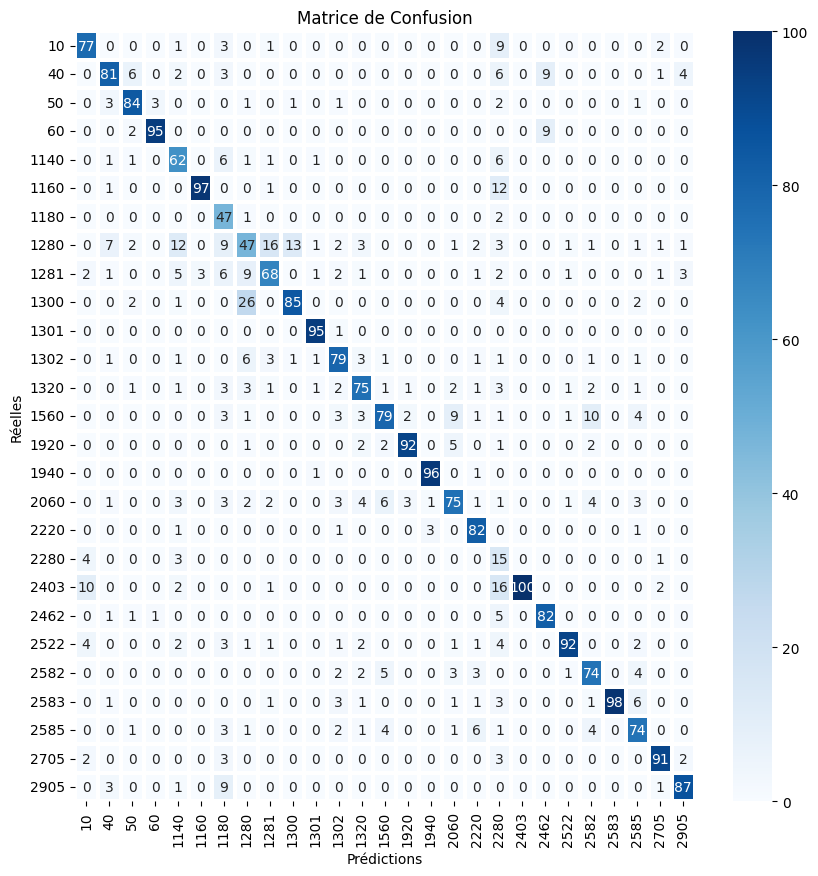

In [4]:
#designation traduction
y_pred_out = y_pred_test.logits
y_pred = np.argmax(y_pred_out, axis=-1)

trainer.evaluateTestResults(y_test,y_pred)

In [8]:
from RktnChallenge.RktnModel import ModelTrainer
import tensorflow as tf


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import  CamembertConfig
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import AdamW

import ast

trainer = ModelTrainer("data_tr_lemm.csv","")
nb_epochs = 10
num_categories = 27
max_features = 400
checkpoint_path = "flaubert_best_desc_sum"

def convert_and_join(str_list):
    try:
        # Convertir la chaîne en liste
        real_list = ast.literal_eval(str_list)
        # Joindre la liste pour former une chaîne
        return " ".join(real_list)
    except (ValueError, SyntaxError):
        return ""



#sentences =  trainer.data["tr_designation"].apply(convert_and_join).values.tolist()
sentences =  trainer.data["tr_description_sum"].values.tolist()
from transformers import FlaubertConfig, TFFlaubertModel, AutoTokenizer

config = FlaubertConfig.from_pretrained(checkpoint_path)
config.num_labels = 27
tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)
model = TFFlaubertModel.from_pretrained(checkpoint_path, config=config)


for layer in model.layers:
    layer.trainable = False


Some layers from the model checkpoint at flaubert_best_desc_sum were not used when initializing TFFlaubertModel: ['sequence_summary']
- This IS expected if you are initializing TFFlaubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFFlaubertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFFlaubertModel were initialized from the model checkpoint at flaubert_best_desc_sum.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFFlaubertModel for predictions without further training.


In [9]:
from tqdm import tqdm

def sentence_to_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors="tf", truncation=True,  max_length=max_features)
    outputs = model(inputs.input_ids)
    embeddings = outputs.last_hidden_state
    
    embeddings = tf.reduce_mean(embeddings, axis=1)    
    return embeddings.numpy()

df = pd.read_csv("embeddings_final.csv")

# embeddings pour chaque texte
df['embeddings_desc_Flaubert'] = [sentence_to_embedding(text) for text in tqdm(sentences)]

df.to_csv("embeddings_final.csv", index=False)

100%|██████████| 84916/84916 [3:39:05<00:00,  6.46it/s]  


In [10]:
print(df['embeddings_desc_Flaubert'][0].shape)

(1, 768)
